# Машинное обучение для определения видов продукции на которой есть повышенный спрос

**Цели работы:**
1. Решить задачу кластеризации колбасных изделий
2. Проверить качество правильного предсказания модели на тестовой выборке

**Задачи работы:**
Так как перед нами стоит задача кластеризации, необходимо присвоить каждому объекту метки: возрастное ограничение, жанр, является кинолента фильмом или сериалом. Для этого необходимо:
1. Предобработать данные
2. Разделить исходный набор данных на тестовую и обучающую выборки
3. Построить модель логистической регрессии
4. Обучить модель на данных обучающей выборки
5. Оценить качество модели с помощью тестовой выборки
6. Сделать выводы

**Ожидаемый результат:**
1. Модель, которая может с высокой вероятностью определить спрос покупателя на определённую продукцию,в определённую заданную дату

**Описание используемого датасета:**
В процессе работы будет использован датасет, состоящий из сериалов и фильмов стримингового сервиса Netflix. Для каждого элемента (фильма или сериала) присутствуют различные показатели, но в рамках данной курсовой работы наиболее важными являются:
1. Тип (фильм или сериал)
2. Краткое описание шоу, данное самим стриминговым сервисом
3. Краткое описание сюжета кинокартины
4. Возрастные ограничения
5. Присутствует ли в киноленте контент для взрослых
6. Жанр 

https://www.kaggle.com/datasets/snehaanbhawal/netflix-tv-shows-and-movie-list

Импортируем все необходимые библиотеки

In [3]:
import pandas as pd #обработка данных
import numpy as np #работа с векторами,матрицами,массивами
 

import matplotlib.pyplot as plt #Визуализация данных(диаграммы)
from wordcloud import WordCloud #Облако слов(тоже визуализация)

import nltk #Обработка естественного языка
from sklearn.feature_extraction.text import TfidfVectorizer #Перевод слов в числовую форму понятную для компьютера

from sklearn.model_selection import train_test_split #разбиение данных на тренировочные и тестовые
from sklearn.linear_model import LinearRegression,Ridge,Lasso #Линейная регрессия
from collections import Counter #Счётчик(нужен для подсчёта колличества)
from nltk.corpus import wordnet #Проводит Лемматизацию, возвращает упрощённые слова, провдя морфологический разбор 
from sklearn.svm import SVC #Метод опорных векторов(не стал использовать ,можно и удалить)
from sklearn.neighbors import KNeighborsClassifier #K ближайших соседей(не стал использовать ,можно и удалить)
from sklearn.feature_selection import SelectKBest, chi2 #Отбор фич (feature selection) — важная составляющая машинного обучения
from sklearn.ensemble import RandomForestClassifier #ещё одна модель обучения(не стал использовать ,можно и удалить)
from sklearn.pipeline import Pipeline #Последовательные стадии преобразования данных, предшествующие их загрузке в Модель
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score, classification_report,explained_variance_score,mean_absolute_error,r2_score #Оценка эффективности обучения модели
from sklearn.naive_bayes import GaussianNB #Импорт наивного баёерского классификатора
from sklearn import tree #для классификации и регрессии 
from sklearn.tree import DecisionTreeClassifier#метод дерева
from sklearn.ensemble import GradientBoostingClassifier# градиентный бустинг
from sklearn.ensemble import AdaBoostClassifier#адаптивный бустинг
nltk.download('punkt')# делит текст на список предложений
nltk.download('wordnet')# проводит лемматизацию
nltk.download('stopwords')# поддерживает удаление стоп-слов
nltk.download('averaged_perceptron_tagger')#Определяет часть речи у токена
from time import time #замер времени
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

Оставляем только нужные для обучения модели столбцы

In [4]:
df = pd.read_csv('netflix_list.csv')
df = df[["type", "summary", "plot", "certificate", "isAdult", "genres"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7008 entries, 0 to 7007
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   type         7006 non-null   object
 1   summary      7008 non-null   object
 2   plot         6609 non-null   object
 3   certificate  2409 non-null   object
 4   isAdult      7008 non-null   int64 
 5   genres       7006 non-null   object
dtypes: int64(1), object(5)
memory usage: 328.6+ KB


Исключаем нанов и дубликатов, смотрим информацию, чтобы свериться, что во всех столбцах одинаковое количество строк

In [5]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2388 entries, 0 to 7006
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   type         2388 non-null   object
 1   summary      2388 non-null   object
 2   plot         2388 non-null   object
 3   certificate  2388 non-null   object
 4   isAdult      2388 non-null   int64 
 5   genres       2388 non-null   object
dtypes: int64(1), object(5)
memory usage: 130.6+ KB


После удаление Nan,как мы видим выше счётчик остался без изменения(Он всё ещё заканчивается на 7006-ом элементе)

Обнуляем счётчик и проверяем

In [6]:
df.reset_index(drop=True, inplace=True)
df

,type,summary,plot,certificate,isAdult,genres
0,tvSeries,"Lucifer Morningstar, bored from his sulking li...",Lucifer Morningstar has decided he's had enoug...,15,0,"Crime,Drama,Fantasy"
1,movie,"With the abandoned, walled city of Las Vegas o...","Following a zombie outbreak in Las Vegas, a gr...",18,0,"Action,Crime,Horror"
2,tvSeries,Michael Douglas plays an actor who made it big...,"An aging actor, who long ago enjoyed a brush w...",18,0,"Comedy,Drama"
3,tvSeries,"Ross Geller, Rachel Green, Monica Geller, Joey...",Follows the personal and professional lives of...,13+,0,"Comedy,Romance"
4,tvSeries,In the small fictional town of Edda coming of ...,A small Norwegian town experiencing warm winte...,18,0,"Action,Drama,Fantasy"
...,...,...,...,...,...,...
2383,tvEpisode,As the Pico Porcupines prepare for a new year ...,As the Pico Porcupines prepare for a new year ...,13+,0,Comedy
2384,tvEpisode,"Rosa, an ambitious and intelligent college stu...","Rosa, an ambitious and intelligent college stu...",18,0,"Drama,Horror,Mystery"
2385,tvEpisode,When his daughter arrives home for the holiday...,When his daughter arrives home for the holiday...,13,0,Comedy
2386,tvEpisode,"The life of Michael Bentt, a champion boxer fo...","The life of Michael Bentt, a champion boxer fo...",16,0,"Documentary,Sport"


Проверяем какие значения имеет "контент для взрослых", как видим все фильмы и сериалы не содержат взрослого контента

In [7]:
df['isAdult'].value_counts()

0    2388
Name: isAdult, dtype: int64

Теперь смотрим какие возрастные ограничения есть в таблице

In [8]:
df['certificate'].value_counts()

18           613
16           415
13           254
R            232
A            147
UA           110
7            109
U            104
PG-13         97
16+           74
18+           57
PG            56
13+           21
All           20
15+           18
Not Rated     16
12+           12
15            11
G              7
7+             6
12             3
(Banned)       3
Unrated        2
NC-17          1
Name: certificate, dtype: int64

Преобразуем все возрастные ограничения разных стран в цифровые ограничения

In [9]:
df = df.replace(['18+','16+','13+','15+','12+','7+',' 18','All','G','NC-17','PG-13','R','PG','U','A','UA'],['18','16','13','15','12','7','18','0+','0+','18','13','17','13','0+','14','12'])
df['certificate'].value_counts()

18           671
16           489
13           428
17           232
14           147
0+           131
12           125
7            115
15            29
Not Rated     16
(Banned)       3
Unrated        2
Name: certificate, dtype: int64

Удаляем строки без рейтинга и запрещённые, так как эти данные нам не понадобятся

In [10]:
list2 = ['Not Rated','(Banned)','Unrated']
df = df[df.certificate.isin(list2) == False]

Ещё раз обнуляем счётчик

In [11]:
df.reset_index(drop=True, inplace=True)

Соединяем обе ячейки, так как и там, и  там находится нужная нам информация по фильмам и сериалам

In [12]:
df['full_text'] = df['summary'] + ' ' + df['plot']

Делаем копию, которая содержит только текст, смотрим первые 5 текстов

In [13]:
df_text = df['full_text'].copy()
df_text.head()

0    Lucifer Morningstar, bored from his sulking li...
1    With the abandoned, walled city of Las Vegas o...
2    Michael Douglas plays an actor who made it big...
3    Ross Geller, Rachel Green, Monica Geller, Joey...
4    In the small fictional town of Edda coming of ...
Name: full_text, dtype: object

Смотрим колличество уникальных слов во всех предложениях

In [14]:
tokenized_raw = [nltk.tokenize.word_tokenize(x) for x in list(df_text)] 
len(set([y for x in tokenized_raw for y in x])) 

22615

Смотрим на диаграмме какие возрастные группы преобладают

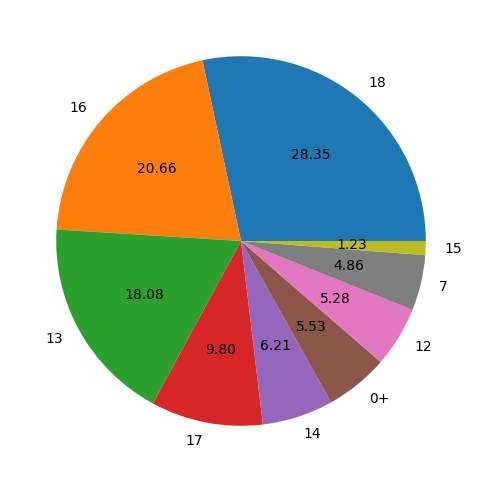

In [15]:
plt.figure(figsize=(12,6))
plt.pie(df['certificate'].value_counts(), labels=['18','16','13','17','14','0+','12','7','15'], autopct='%0.2f')
plt.show()

Создаём массив стоп-слов

In [16]:
stop = nltk.corpus.stopwords.words('english')
stop.append(':')
stop.append(',')
stop.append('.')
stop.append('?')
stop.append('!')
stop.append('(')
stop.append(')')
stop.append('-')
stop.append('[')
stop.append(']')
stop.append('the')
stop.append('...')
stop.append('&')
stop.append('..')
stop.append(';')
stop.append('n\'t')
stop.append('’')
stop.append('a')
stop.append('wa')
stop.append('\'s')
stop.append("''")
stop.append('``')
stop.append('2')
stop.append('4')
stop.append('#')
stop.append('*')

# Токенизация, исключение стоп слов и схожих слов.
функция process обрабатывает текст(токенизация,лемматизация по возращённому значению из функции get_wordnet_pos) возвращает обработанную строчку датасета
функция get_wordnet_pos определяет часть речи слова и возвращает это слова в виде существительного
функция joins принимает значение от функции process и создаёт массив из разрозненных строк

In [17]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
lemmatize = nltk.WordNetLemmatizer()
def process(description):
  string = []
  for i in description:
    words = [nltk.word_tokenize(i, language = "english")]
    word1 = [word.lower() for x in words for word in x if word.lower() not in stop]
    wordss = [lemmatize.lemmatize(x, get_wordnet_pos(x)) for x in word1 ]
    string.append(wordss)
  return string

def joins(description):
  df_stream =[]
  for i in description:
    string = [' '.join(i)]
    df_stream.append(string)
  return df_stream
steem = joins(process(df_text))

Добавляем в наш датасет новую столбец с обработанным текстом

In [18]:
df['clean_text'] = pd.DataFrame(steem)

Смотрим, что получилось

In [19]:
df

,type,summary,plot,certificate,isAdult,genres,full_text,clean_text
0,tvSeries,"Lucifer Morningstar, bored from his sulking li...",Lucifer Morningstar has decided he's had enoug...,15,0,"Crime,Drama,Fantasy","Lucifer Morningstar, bored from his sulking li...",lucifer morningstar bore sulk life hell come l...
1,movie,"With the abandoned, walled city of Las Vegas o...","Following a zombie outbreak in Las Vegas, a gr...",18,0,"Action,Crime,Horror","With the abandoned, walled city of Las Vegas o...",abandon wall city la vega overrun zombie disas...
2,tvSeries,Michael Douglas plays an actor who made it big...,"An aging actor, who long ago enjoyed a brush w...",18,0,"Comedy,Drama",Michael Douglas plays an actor who made it big...,michael douglas play actor make big long time ...
3,tvSeries,"Ross Geller, Rachel Green, Monica Geller, Joey...",Follows the personal and professional lives of...,13,0,"Comedy,Romance","Ross Geller, Rachel Green, Monica Geller, Joey...",ross geller rachel green monica geller joey tr...
4,tvSeries,In the small fictional town of Edda coming of ...,A small Norwegian town experiencing warm winte...,18,0,"Action,Drama,Fantasy",In the small fictional town of Edda coming of ...,small fictional town edda come age people forc...
...,...,...,...,...,...,...,...,...
2362,tvEpisode,As the Pico Porcupines prepare for a new year ...,As the Pico Porcupines prepare for a new year ...,13,0,Comedy,As the Pico Porcupines prepare for a new year ...,pico porcupine prepare new year outdoor advent...
2363,tvEpisode,"Rosa, an ambitious and intelligent college stu...","Rosa, an ambitious and intelligent college stu...",18,0,"Drama,Horror,Mystery","Rosa, an ambitious and intelligent college stu...",rosa ambitious intelligent college student try...
2364,tvEpisode,When his daughter arrives home for the holiday...,When his daughter arrives home for the holiday...,13,0,Comedy,When his daughter arrives home for the holiday...,daughter arrives home holiday quinn force put ...
2365,tvEpisode,"The life of Michael Bentt, a champion boxer fo...","The life of Michael Bentt, a champion boxer fo...",16,0,"Documentary,Sport","The life of Michael Bentt, a champion boxer fo...",life michael bentt champion boxer force sport ...


Проверяем на сколько уменьшилось колличество уникальных слов после обработки текста

In [20]:
text_corpus = []
text_abc = [word.split(' ') for word in df['clean_text'].tolist()]
for mail in text_abc:
  for word in mail:
    text_corpus.append(word)

len(set(text_corpus))

17188

Генерируем облако слов, чем крупнее слово ,тем чаще оно встречается

In [21]:
y =' '.join(text_corpus)
wordcloud_y = WordCloud(width=1600, height=800).generate(y)

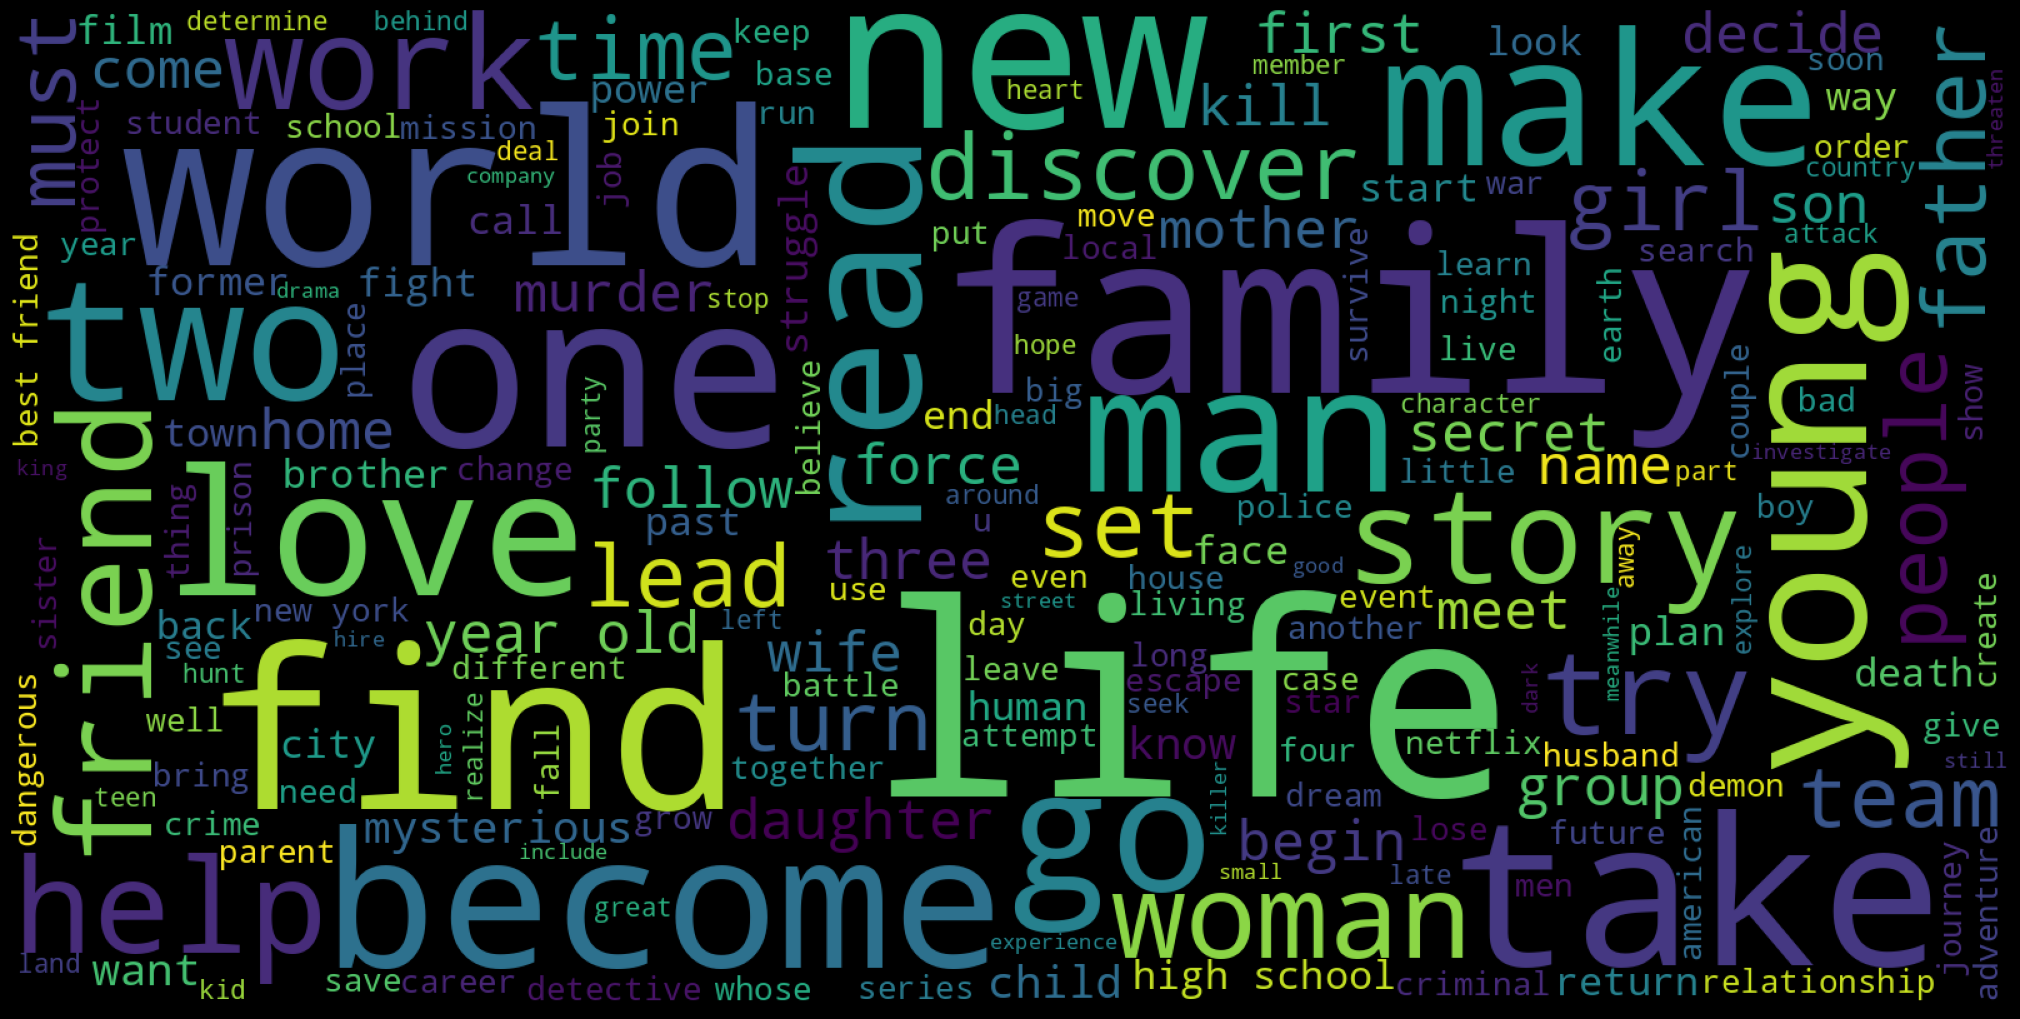

In [22]:
plt.figure( figsize=(20,10), facecolor='k')
# добавляем туда облако слов
plt.imshow(wordcloud_y)
# выключаем оси и подписи
plt.axis("off")
# убираем рамку вокруг
plt.tight_layout(pad=0)
# выводим картинку на экран
plt.show()

У меня всё отображается корректно, попробуйте использовать Colab

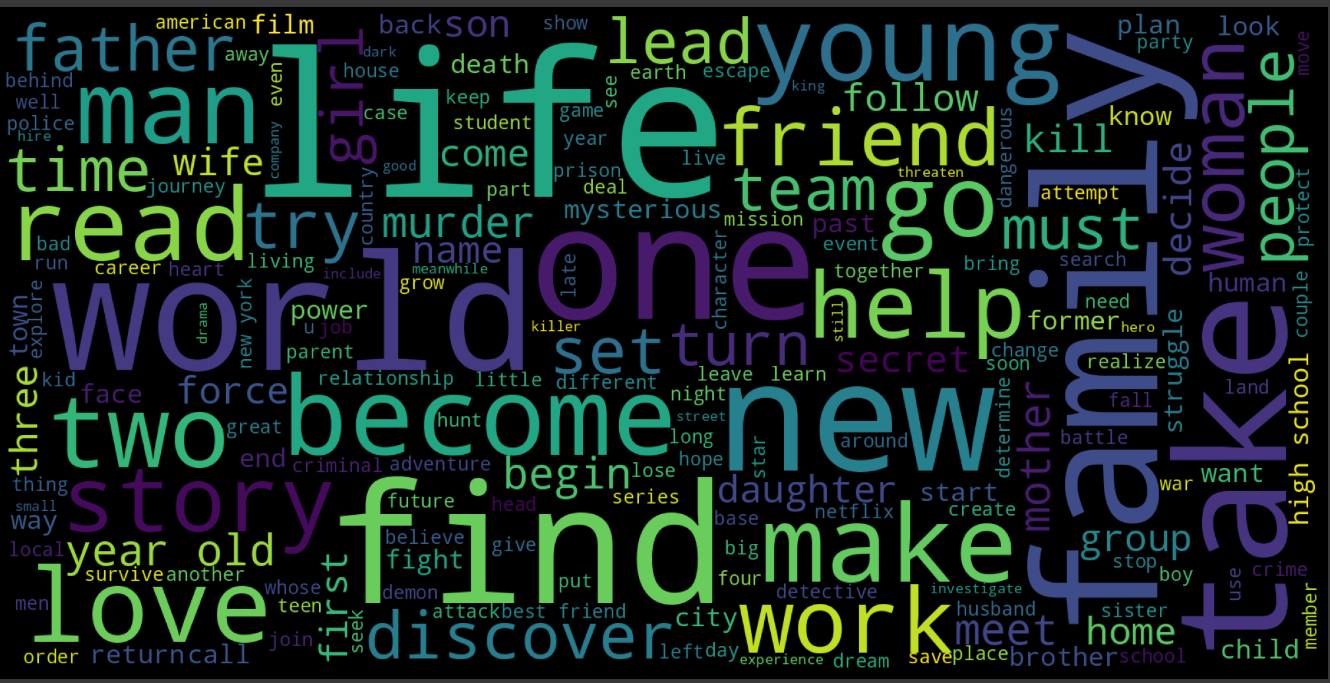

Удаляем непонятный жанр

In [24]:
df = df[df.genres != '\\N']

Ещё раз удаляем повторы и пустые значения

In [25]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

<ipython-input-25-5110ff77c3d8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


Некоторые жанры состоят из нескольких слов, мы пробегаемся по каждой строке датасета и разделяем подобные перечесления на отдельные слова.

Например,
['Боевик,Приключения,Триллер'] --> ['Боевик','Приключения','Триллер']
Так же подсчитываем колличество уникальных жанров(в сложных жанрах считаем,что ключевой жанр является первым,чтобы не было слишком много классов)

In [26]:
text_corpus2 = []
text_abc2 = [word.split(',') for word in df['genres'].tolist()]
for sentence in text_abc2:
  for word in sentence:
    text_corpus2.append(word)

len(set(text_corpus2))

27

Добавляем эти жанры в список

In [27]:
spisok = [i for i in set(text_corpus2)]

В сложных жанрах считаем,что ключевой жанр является первым,чтобы не было слишком много классов, удаляем остальные классы, оставляем только первые в кажой строчке датасета

In [28]:
text_abc3 = [[sentence[0]] for sentence in text_abc2]
df['genres'] = pd.DataFrame(text_abc3)

<ipython-input-28-d955c3703144>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genres'] = pd.DataFrame(text_abc3)


Создаём словарь, нумеруем каждый жанр от 0 до 26, чтобы обучать модель, меняем название жанра на число в датасете

In [29]:
res = dict(zip(spisok, [i for i in range(len(spisok))]))
df.replace(res,inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

<ipython-input-29-3eeb53ba5f7a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace(res,inplace=True)
<ipython-input-29-3eeb53ba5f7a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


Берём за X очищенный текст и по нему будем обучать модель определять y(жанр фильма)

In [30]:
tfidf = TfidfVectorizer()

X = df['clean_text']
y = df['genres']

In [31]:
df['clean_text'].shape

(2365,)

Разбиваем данные на обучающую и тест выборку.

In [32]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

Обучение логистической регрессии

Этот код не менял, вам нужно его просто запустить,я его не запускал

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([
                ('vect', CountVectorizer(analyzer='char', ngram_range =(2,10))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=3,C=1e5, solver='saga', 
                                           multi_class='multinomial',
                                           max_iter=1000,
                                           random_state=42)),
])
start = time()
logreg.fit(X_train, y_train)
train_time = time() - start
start = time()
y_pred = logreg.predict(X_test)
predict_time = time()-start
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
print(classification_report(y_test, y_pred))
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)

KeyboardInterrupt: ignored

Используется CountVectorizer на ngram с analyzer = char. Именно такой подход дал наилучшую точность на маленьких текстах. В зависимости от данных значение ngram можно корректировать. Целевая метрика – F1.

# Изменяем возрастные ограничение на числа от 0 до 8, чтобы обучить модель определять по тексту возрастное ограничение фильма/сериала

In [ ]:
df = df.replace(['18','16','13','17','14','0+','12','7','15'],['0','1','2','3','4','5','6','7','8'])

Проделываем те же шаги, что и с жанрами

In [ ]:
X2 = df['clean_text']
y2 = df['certificate']

In [ ]:
X_train2,X_test2,y_train2,y_test2 = train_test_split(X2,y2,test_size=0.25,random_state=42)

In [ ]:
logreg = Pipeline([
                ('vect', CountVectorizer(analyzer='char', ngram_range =(3,15))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=3,C=1e5, solver='saga', 
                                           multi_class='multinomial',
                                           max_iter=1000,
                                           random_state=42)),
])

start = time()
logreg.fit(X_train2, y_train2)
train_time = time() - start
start = time()
y_pred2 = logreg.predict(X_test2)
predict_time = time()-start
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
print(classification_report(y_test2, y_pred2))
print(f"F1 Score: {f1_score(y_test2, y_pred2, average='weighted')}")
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)

Список используемой литературы:
https://www.helenkapatsa.ru/paiplain/
https://habr.com/ru/companies/ods/articles/323890/
https://habr.com/ru/articles/514818/
https://habr.com/ru/articles/264915/

инициализирует объект класса TfidfVectorizer().Это нам нужно в дальнейшем, чтобы переводить слова из очищенного текста в цифры от 0 до 1, чтобы компьютер нас понимал,точно так же мы до этого заменили жанры числами

In [34]:
tfidf = TfidfVectorizer()

x = tfidf.fit_transform(df['clean_text'])
y = df['genres']
x_train3,x_test3,y_train3,y_test3 = train_test_split(x,y,test_size=0.25,random_state=42)


Обучаем несколько моделей KNN(k ближайших соседей), смотрим какое значение параметра k самое оптимальное

In [ ]:
accuracy = []
num_neigh = []

for ii in range(10,200):
    knc = KNeighborsClassifier(n_neighbors=ii)
    knc.fit(x_train3,y_train3)
    accuracy.append(knc.score(x_test3,y_test3))
    num_neigh.append(ii)

print(accuracy)
plt.scatter(num_neigh,accuracy)
plt.xlabel('Number of neighbours')
plt.ylabel('Accuracy')
plt.show();

Сужаем диапазон подбора значений от 50 до 75, так как в этом диапазоне самый высокие показатель

In [ ]:
accuracy = []
num_neigh = []

for ii in range(50,75):
    knc = KNeighborsClassifier(n_neighbors=ii)
    knc.fit(x_train3,y_train3)
    
    accuracy.append(knc.score(x_test3,y_test3))
    num_neigh.append(ii)

print(accuracy)
plt.scatter(num_neigh,accuracy)
plt.xlabel('Number of neighbours')
plt.ylabel('Accuracy')
plt.show();

Искомое значение 67

In [105]:
knc = KNeighborsClassifier(67)
start = time()
knc = knc.fit(x_train3,y_train3)
train_time = time() - start
start = time()
y_pred3 = knc.predict(x_test3)
predict_time = time()-start
print(classification_report(y_test3, y_pred3))
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00         2
           4       0.50      0.09      0.16        32
           6       1.00      0.02      0.05        41
           7       0.40      0.84      0.54       115
           8       0.54      0.76      0.63       152
           9       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00        12
          20       0.32      0.27      0.29        98
          21       0.64      0.38      0.47        74
          22       0.00      0.00      0.00        29
          25       0.00      0.00      0.00         4
          26       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Обучаем модель метод опорных векторов

In [ ]:
svc = SVC()
start = time()
svc.fit(x_train3,y_train3)
train_time = time() - start
start = time()
y_pred3 = svc.predict(x_test3)
predict_time = time()-start
print(classification_report(y_test3, y_pred3))
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)

На основе [этой](https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769) статьи делаем поправки и улучшаем точность модели

In [ ]:
svc = SVC(kernel='sigmoid', C=100, gamma=0.01)
start = time()
svc.fit(x_train3,y_train3)
train_time = time() - start
start = time()
y_pred3 = svc.predict(x_test3)
predict_time = time()-start
print(classification_report(y_test3, y_pred3))
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)

обучения наивного байерского классификатора

In [ ]:
x = tfidf.fit_transform(df['clean_text']).toarray()
y = df['genres']
x_train4,x_test4,y_train4,y_test4 = train_test_split(x,y,test_size=0.25,random_state=42)


In [ ]:
gaussianNB = GaussianNB()
start = time()
gaussianNB.fit(x_train4,y_train4)
train_time = time() - start
start = time()
y_pred4 = gaussianNB.predict(x_test4)
predict_time = time()-start
print(classification_report(y_test4, y_pred4))
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)

Теперь можно попробовать рассмотреть некоторые ансамблевые методы машинного обучения, такие как адаптивный бустинг и градиентный бустинг. Что мы знаем про ансамблевые методы? В ансамблевых методах несколько моделей обучаются для решения одной и той же проблемы и объединяются для получения более эффективных результатов. Основная идея заключается в том, что при правильном сочетании моделей можно получить более точную и надежную модель.
Обучаем адаптивный бустинг

In [ ]:
modelClf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.33, random_state = 42)
start = time()
modelClf.fit(X_train, y_train)
train_time = time() - start
start = time()
y_pred4 = modelClf.predict(X_valid)
predict_time = time()-start
print(classification_report(y_valid, y_pred4))
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)

Градиентный бустинг, также как и адаптивный, обучает слабые алгоритмы последовательно, исправляя ошибки предыдущих. Принципиальное отличие этих алгоритмов заключается в способах изменения весов. Адаптивный бустинг использует итеративный метод оптимизации, в то время как градиентный оптимизирует веса с помощью градиентного спуска.
Обучаем  градиентный бустинг

In [ ]:
modelClf = GradientBoostingClassifier(max_depth=2, n_estimators=150,random_state=12, learning_rate=1)
start = time()
modelClf.fit(x_train4, y_train4)
train_time = time() - start
start = time()
y_pred4 = modelClf.predict(X_valid)
predict_time = time()-start
print(classification_report(y_valid, y_pred4))
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)

Обучаем новую модель по гиперпараметрам,задаём отрезки значений в них,чтобы найти лучшие параметры,которые покажут наибольшее значение на выходе

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
from scipy.stats import randint

rs_space={'max_depth':list(np.arange(10, 100, step=10)) + [None],
              'n_estimators':np.arange(10, 500, step=50),
              'max_features':randint(1,7),
              'criterion':['gini','entropy'],
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(2, 10, step=2)
}

In [37]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(rf, rs_space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=3)
start = time()
model_random = rf_random.fit(x,y)
train_time = time() - start

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Выводим наибольшую оценку и те гиперпараметры,которые её дали

In [38]:
print('Best hyperparameters are: '+str(model_random.best_params_))
print('Best score is: '+str(model_random.best_score_))
print("\tTraining time: %0.3fs" % train_time)

Best hyperparameters are: {'criterion': 'gini', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 460}
Best score is: 0.4295897053178325


Смотрим наибольшую оценку у нескольких моделей(Knn ,Ridge лидируют)

In [40]:
regressors = [
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge()
]

тренируем модели,смотрим время обучения каждой и их точность, в целом я поменял подход ,так что код выше с моделями обучения можно убрать(те модели,которые были до поправок)

In [42]:
head = 10
for model in regressors[:head]:
    start = time()
    model.fit(x_train3, y_train3)
    train_time = time() - start
    start = time()
    y_pred = model.predict(x_test3)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

KNeighborsRegressor()
	Training time: 0.003s
	Prediction time: 3.152s
	Explained variance: 0.053698323336056175
	Mean absolute error: 6.1925675675675675
	R2 score: 0.04648553305518799

GradientBoostingRegressor()
	Training time: 9.270s
	Prediction time: 0.006s
	Explained variance: 0.09185700025155197
	Mean absolute error: 6.240722015645841
	R2 score: 0.09139261527431974

KNeighborsRegressor()
	Training time: 0.001s
	Prediction time: 2.434s
	Explained variance: 0.05370920528750989
	Mean absolute error: 6.191891891891892
	R2 score: 0.04651266917675789

ExtraTreesRegressor()
	Training time: 160.191s
	Prediction time: 0.060s
	Explained variance: 0.020600220114283196
	Mean absolute error: 5.8583445945945956
	R2 score: 0.01877254502900183

RandomForestRegressor()
	Training time: 127.205s
	Prediction time: 0.057s
	Explained variance: 0.11224662992085388
	Mean absolute error: 5.919684684684685
	R2 score: 0.11181824564974052

DecisionTreeRegressor()
	Training time: 1.584s
	Prediction time: 0.00

Импортируем библиотеки для Grid Search для  модели Ridge() 

In [54]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import RepeatedKFold

Инициализируем объект ,настраиваем парметры во второй строке

In [55]:
model = Ridge()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

задаём отрезок гиперпараметров,чтобы подобрать лучший из них

In [102]:
param_grid = {"alpha": 10.0 ** np.arange(-5, 6),
    'solver':['svd', 'cholesky', 'lsqr', 'sag'],
    'fit_intercept':[True, False]
}

Обучаем модель по гиперпараметрам

In [103]:
search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)
start = time()
result = search.fit(x, y)
train_time = time() - start

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
990 fits failed out of a total of 2640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
330 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py", line 1134, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py", line 840, in fit
    raise ValueError(
ValueError: solver='svd' does not s

Выводим наибольшую оценку и те гиперпараметры,которые её дали

In [104]:
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
print("\tTraining time: %0.3fs" % train_time)

Best Score: -5.5966049170393894
Best Hyperparameters: {'alpha': 0.1, 'fit_intercept': True, 'solver': 'lsqr'}


Отрицательное значение говорит о том,что бывают ситуации, когда коэффициент принимает отрицательные значения (обычно небольшие). Это произошло, потому что ошибка модели среднего стала меньше ошибки модели с переменной. В этом случае оказывается, что добавление в модель с константой некоторой переменной только ухудшает её (т.е. регрессионная модель с переменной работает хуже, чем предсказание с помощью простой средней), поэтому обучим ещё одну модель KNeighborsClassifier()

Обучаем модель и сравниваем результаты в промежутке от 1 до 310

In [109]:
knn = KNeighborsClassifier()
k_range = list(range(1, 310))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
start = time()
grid_search=grid.fit(x_train3, y_train3)
train_time = time() - start

Fitting 10 folds for each of 309 candidates, totalling 3090 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Наиболее высокий результат дал гиперпараметр K со значением 119

In [112]:
print(grid_search.best_params_)
print("\tTraining time: %0.3fs" % train_time)

{'n_neighbors': 119}
	Training time: 0.031s


Выводим точность модели

In [111]:
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Accuracy for our training dataset with tuning is : 43.65%


Таким образом,наилучшей моделью для данной задачи является KNeighborsClassifier()